# IEEE-CIS Fraud Detection Part 2

In this series of notebooks, we are working on a supervised, regression machine learning problem. Using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) dataset, we want to predict whether a transaction is fraud or not. 

 ### Workflow 
 1. Understand the problem (we're almost there already)
 2. Exploratory Data Analysis
 3. Feature engineering to create a dataset for machine learning
 4. Create a baseline machine learning model
 5. Try more complex machine learning models
 6. Optimize the selected model
 7. Investigate model predictions in context of problem
 8. Draw conclusions and lay out next steps
 
The first notebook covered steps 1-3, and in this notebook, we will cover 4-6.

# Read in Data



In [4]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import f1_score,roc_auc_score, confusion_matrix, classification_report, accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Datetime
from datetime import datetime

# Import data
import warnings

# Dask 
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client

from dask_ml.preprocessing import OneHotEncoder, MinMaxScaler
from dask_ml.datasets import make_regression
from dask_ml.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from dask_ml.linear_model import LogisticRegression
from dask_ml.xgboost import XGBClassifier
from dask_ml.wrappers import ParallelPostFit

from sklearn.externals.joblib import parallel_backend

In [2]:
# Load Data
df = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/clean_train.csv')

In [3]:
# Display sizes of data
print('Training Feature Size: ', df.shape)

Training Feature Size:  (590540, 1704)


In [4]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,browser_info_verykoolS5019,browser_info_verykoolS5524,browser_info_verykoolS5525,browser_info_verykoolS5530,browser_info_verykools4009,browser_info_verykools5004,browser_info_verykools5034,browser_info_verykools5035,browser_info_vivo,browser_info_xs-Z47b7VqTMxs
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,0,0,0,0,0,0,0,0,0,0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0,0,0,0,0,0,0,0,0,0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0,0,0,0,0,0,0,0,0,0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0,0,0,0,0,0,0,0,0,0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 1704 entries, TransactionID to browser_info_xs-Z47b7VqTMxs
dtypes: float64(402), int64(1302)
memory usage: 7.5 GB


# Evaluating and Comparing Machine Learning Models
In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

## Split Train and Test set¶
Let's split dataset by using function train_test_split(). Here, the Dataset is broken into two parts in a ratio of 80:20. It means 80% data will be used for model training and 20% for model testing.

To continue feature selection, we will start by using the original attributes in the raw training set.

In [6]:
# Y is the target variable
y = df['isFraud']

# X is the feature set
X = df.drop(labels=['TransactionID','TransactionDT','isFraud'], axis=1).fillna(0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [9]:
print('X_shapes:\n', 'X_train:', 'X_test:\n', X.shape, X_test.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_test:\n', y_train.shape, y_test.shape)

X_shapes:
 X_train: X_test:
 (472432, 1701) (118108, 1701) 

Y_shapes:
 Y_train: Y_test:
 (472432,) (118108,)


### Imputing Missing Values 
Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Imputing also helps to reduce bias due to missingness: ‘rather than deleting cases that are subject to item-nonresponse, the sample size is maintained resulting in a potentially higher efficiency than for case deletion'[Durrant](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146#).

Here, we will fill in missing values with the median of the column.

In [10]:
# Create an imputer object with a median filling strategy
#imputer = SimpleImputer(strategy='median')

# Train on the training features
#imputer.fit(X_train)

# Transform both training data and testing data
#X = imputer.transform(X_train)
#X_test = imputer.transform(X_test)

In [11]:
#print('Missing values in training features: ', np.sum(np.isnan(X)))
#print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

In [12]:
# Make sure all values are finite
#print(np.where(~np.isfinite(X)))
#print(np.where(~np.isfinite(X_test)))

After imputation, all of the features are real-valued.

### Scaling Features
The final step to take before we can build our models is to scale the features. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.

In [13]:
# Create the scaler object with a range of 0-1
#scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
#scaler.fit(X)

# Transform both the training and testing data
#X = scaler.transform(X)
#X_test = scaler.transform(X_test)

In [14]:
# Convert y to one-dimensional array (vector)
#y = np.array(train_labels).reshape((-1, ))
#y_test = np.array(test_labels).reshape((-1, ))

# Baseline 
For a naive baseline, we will use logistic regression to predict the probability of fraud occurrence. Unlike linear regression which gives continuous output, logistic regression provides a constant output in prediciting binary classes. If the probability 'p' is greater than 0.5, the data is labeled '1'. Probability less than 0.5 is labeled as '0'.

## Logistic Regression Implementation
First, we'll create the model and train the model and make predictions on the testing data.

In [15]:
# Logisitic Regression 
start_time = datetime.now()

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()

# Fit the model with data
logreg.fit(X, y_train)

# Predict on test set
y_pred=logreg.predict(X_test)

# Compute ROC AUC score, accuracy score, confusion matrix, and classification report
print('ROC AUC score: %0.4f' % roc_auc_score(y_test, y_pred))
print('Accuracy score: %0.4f' % accuracy_score(y_test, y_pred))      
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ROC AUC score: 0.5266
Accuracy score: 0.9649
[[113732    134]
 [  4011    231]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113866
           1       0.63      0.05      0.10      4242

   micro avg       0.96      0.96      0.96    118108
   macro avg       0.80      0.53      0.54    118108
weighted avg       0.95      0.96      0.95    118108


Duration: 0:04:51.067313


As we can see, the ROC AUC and accuracy scores are very different. This model has an accuracy score of 96.5%. The score is calculated by adding the true positive and true negative values of 113,732 and 231 and dividing by the total count of 118,108. In contrast, the ROC AUC score is close to a random guess score of 52.7%. From the confusion matrix, we failed to flag 134 transactions as fraud out of 113,732 fraudulent transactions. 

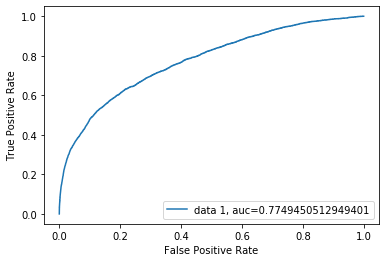

In [16]:
# ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The predicted probability of the logistic regression basline scored around 0.77 which is better than random guess score of 0.5.


## Improved Model: Random Forest
Let's try using a Random Forest on the same training data to see if it will beat the performance of our baseline. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [17]:
# Random Forest Classifer
start_time = datetime.now()

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X, y_train)

y_pred=clf.predict(X_test)

# Compute ROC AUC score, accuracy score, confusion matrix, and classification report
print('ROC AUC score: %0.4f' % roc_auc_score(y_test, y_pred))
print('Accuracy score: %0.4f' % accuracy_score(y_test, y_pred))      
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

ROC AUC score: 0.7070
Accuracy score: 0.9781
[[113765    101]
 [  2482   1760]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.95      0.41      0.58      4242

   micro avg       0.98      0.98      0.98    118108
   macro avg       0.96      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108


Duration: 0:11:04.405963


The ROC AUC and accuracy score for this model has increased from the baseline model indicating that random forest is a the better model for this data. 

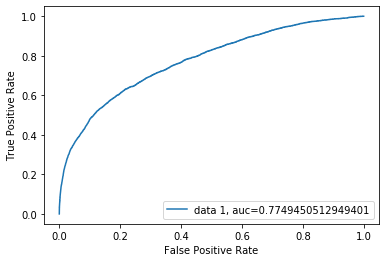

In [18]:
# ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

This graph looks exactly like the baseline model. I'm not sure if this kernel ran properly. 

### Model Interpretation: Feature Importances
As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. We may use these feature importances as a method of dimensionality reduction in future work.

In [22]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

ValueError: Shape of passed values is (1701, 1), indices imply (1704, 1)

In [23]:
#'Feature_importances_' from random forest
print((feature_importances).head(10))

NameError: name 'feature_importances' is not defined

## Models to Evaluate
We will compare five different machine learning models:

1. Logistic Regression
2. Random Forest Classifer
3. Support Vector Machine 
4. K-Nearest Neighbors Classifer
5. Extreme Gradient Boosting Classifer

In [26]:
# Function to calculate roc auc score
def auc(y_test, y_pred_proba):
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    return auc

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    # Train the model
    model.fit(X, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_auc = auc(y_test, model_pred)
    
    # Return the performance metric
    return model_auc

In [27]:
# Logisitic Regression 
start_time = datetime.now()

lr = LogisticRegression()
lr_score = fit_and_evaluate(lr)

print('Logistic Regression Performance on the test set: ROC_AUC = %0.4f' % lr_score)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Performance on the train set: ROC_AUC = 0.5266

Duration: 0:04:48.762240


In [28]:
# Random Forest Classifer
start_time = datetime.now()

rfc = RandomForestClassifier()
rfc_score = fit_and_evaluate(rfc)

print('RandomForestClassifier Performance on the test set: ROC_AUC = %0.4f' % rfc_score)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier Performance on the train set: ROC_AUC = 0.6933

Duration: 0:01:29.356179


In [ ]:
# Support Vector Classifer
start_time = datetime.now()

smv = SVC()
smv_score = fit_and_evaluate(smv)

print('SVC Performance on the test set: ROC_AUC = %0.4f' % smv_score)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [ ]:
# KNN Classifer 
start_time = datetime.now()

knn = KNeighborsClassifier()
knn_score = fit_and_evaluate(knn)

print('KNN Classifier Performance on the test set: ROC_AUC = %0.4f' % knn_score)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [ ]:
# Extreme Gradient Boosting Classifer 
start_time = datetime.now()

xgb = XGBClassifier()
xgb_score = fit_and_evaluate(xgb)

print('XGB Classifier Performance on the test set: ROC_AUC = %0.4f' % xgb_score)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [ ]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'Model': ['Logistic Regression', 'RandomForest Classifier',
                                           'Support Vector Classifer', 'KNeighbors Classifier', 'XGB Classifier'],
                                 'ROC_AUC': [lr_score, rfc_score, svc_score, knn_score, xgb_score]})

# Horizontal bar chart of test mae
model_comparison.sort_values('ROC_AUC', ascending = True)

# Conclusion 
We followed the general outline of a machine learning project:

1. Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5. Improved model
6. Model interpretation (just a little)